<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 22
# Student 1: Ruichen Hu
# Student 2: Simin Sun
# Student 3: Siyue Chen

In [ ]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [ ]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [ ]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all training images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


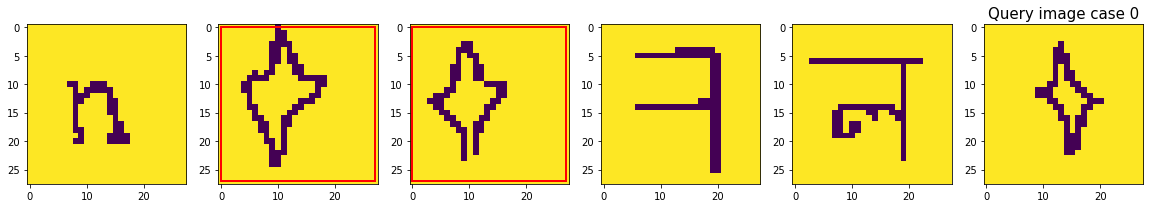

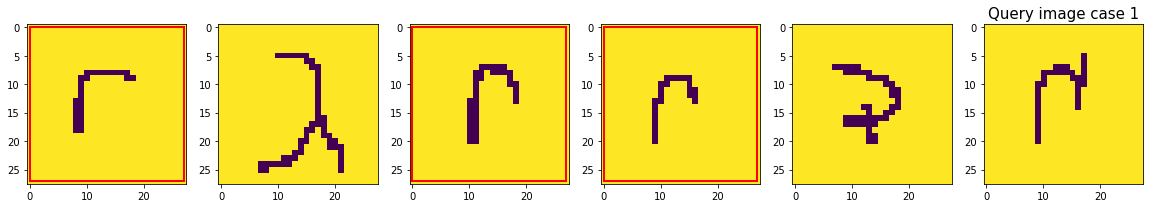

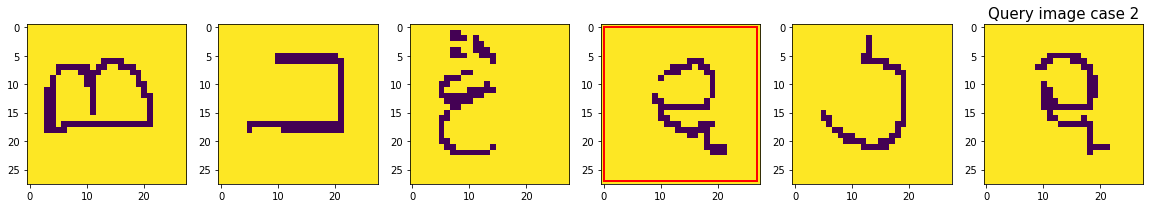

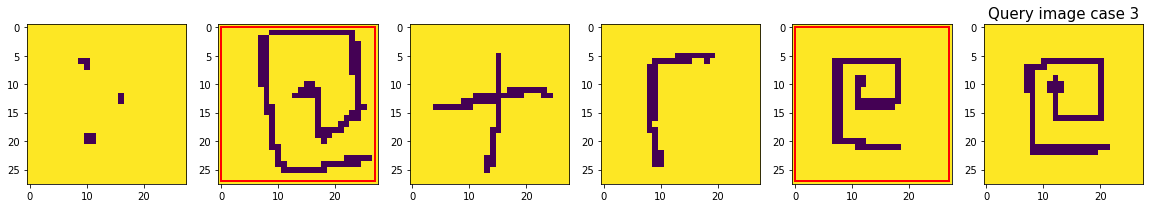

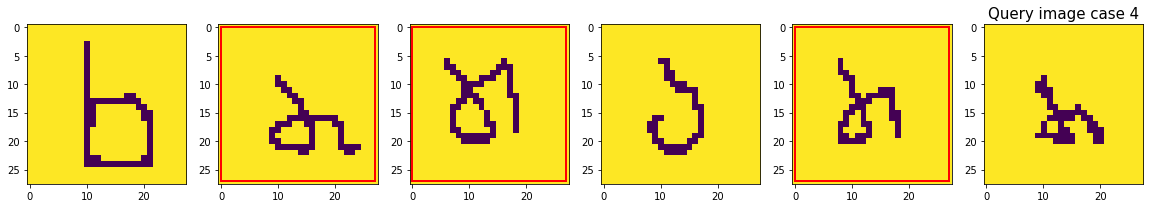

In [ ]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [ ]:
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



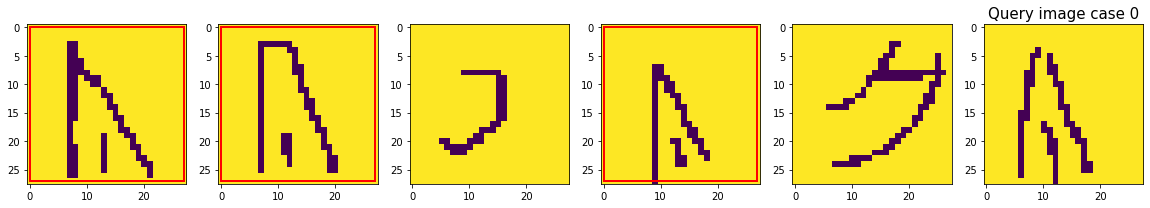

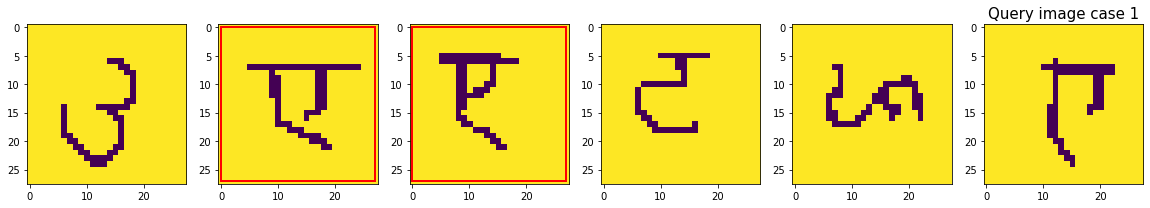

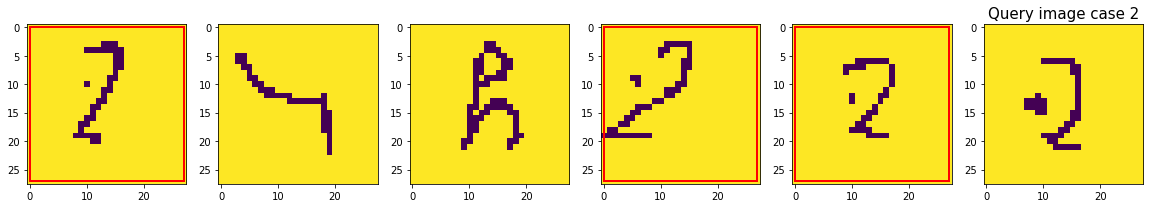

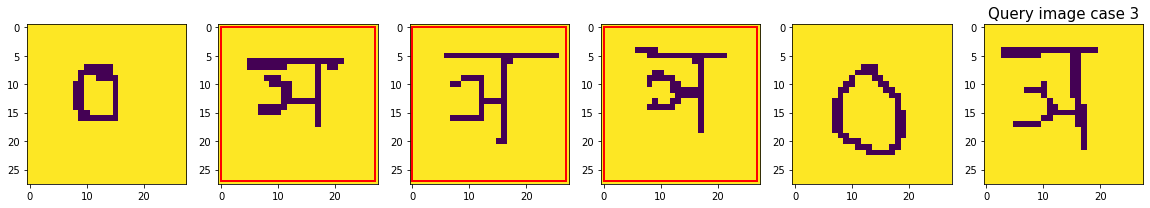

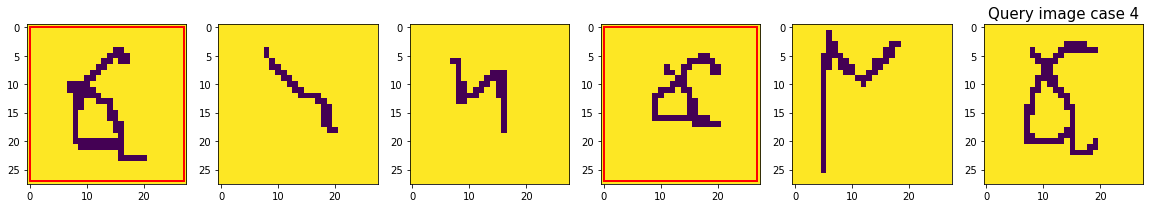

In [ ]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
# transform = transforms.ToTensor()
train_dataset=MyDataset(train_data,train_label)
test_dataset=MyDataset(test_data,test_label)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [ ]:
## Task  ##

In [ ]:
## Build Sample Selector ##
BATCH_SIZE = 50

# For each set, combine the first 5 images with the query image respectively and get 5 pairs of training data.
def make_dataloader(dataset):
  x1 = []
  x2 = []
  label = []
  for x, y in dataset:
    for i in range(len(y)):
      x1.append(np.array(torch.unsqueeze(x[i], 0).numpy()))
      x2.append(np.array(torch.unsqueeze(x[5], 0).numpy()))
      label.append(torch.unsqueeze(y[i], 0).numpy())
  x1 = torch.tensor(np.array(x1))
  x2 = torch.tensor(np.array(x2))
  label = torch.tensor(np.array(label))
  triple = TensorDataset(x1, x2, label)
  # train: 10000*5 -> 1000 batches * size(50)
  # test: 1000*5 -> 100 batches * size(50)
  dataloader = DataLoader(triple, batch_size=BATCH_SIZE) 
  return dataloader

pair_train_loader = make_dataloader(train_dataset)
pair_test_loader = make_dataloader(test_dataset)

In [ ]:
## Model Definition ##
from torch.nn.modules.activation import ReLU
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()
    self.cnn1 = nn.Sequential(
        # input: Batch size(50) * 1 * 28 * 28
        nn.Conv2d(1, 32, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),

        # 50 x 32 x 13 x 13
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),

        # 50 x 64 x 5 x 5
        nn.ReflectionPad2d(1),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),

        # 50 x 128 x 5 x 5
        nn.ReflectionPad2d(1),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128)

    )

    self.fc1 = nn.Sequential(
        # 50 x 128 x 5 x 5
        nn.Linear(128*5*5, 128),
        nn.ReLU(inplace=True),
        
        # 50 x 128
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),

        # output dimension: an arbitrary value
        # 50 x 10
        nn.Linear(128, 10)
    )

  def half_pass(self, input):
    out = self.cnn1(input)
    out = out.view(out.size()[0], -1) # 50 x (32 x 5 x 5)
    out = self.fc1(out)
    return out

  def forward(self, x1, x2):
    out1 = self.half_pass(x1)
    out2 = self.half_pass(x2)
    return out1, out2

In [ ]:
## LOSS Definition ##
class ContrastiveLoss(nn.Module):
  def __init__(self, device, margin=0.2):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
    self.device = device
  
  def forward(self, X1, X2, y):
    # X1, X2: condense 50 imgs in one vector, y: label for each img pair; y=1: same class; y = 0: different class
    dist = F.pairwise_distance(X1, X2, keepdim = True)   # 50 x 1
    batch_loss = torch.sum(y * torch.pow(dist, 2) + (1 - y) * torch.pow(torch.maximum(self.margin - dist, torch.zeros(BATCH_SIZE, 1).to(self.device)), 2))
    return batch_loss, dist

In [ ]:
LEARNING_RATE = 0.001
REGULARIZATION_RATE = 0.05

## TO DO ##
# margin should be twice the average Euclidean distance between features of training image pairs before learning
MARGIN = 0.3

MOMENTUM = 0.9

def config_model():
  model = Siamese()
  device = torch.device(
      "cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)

  loss_function = ContrastiveLoss(margin=MARGIN, device=device)
  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION_RATE, momentum=MOMENTUM)
  return model, loss_function, optimizer, device

Epoch: 0 	Training Loss: 0.011348750566840171
Epoch: 1 	Training Loss: 0.007859797753691673
Epoch: 2 	Training Loss: 0.007182168480455876
Epoch: 3 	Training Loss: 0.006922982262670994
Epoch: 4 	Training Loss: 0.006781164486706257
Epoch: 5 	Training Loss: 0.006682599625587464
Epoch: 6 	Training Loss: 0.006584761443734169
Epoch: 7 	Training Loss: 0.0064162091067433355
Epoch: 8 	Training Loss: 0.006329963045716286
Epoch: 9 	Training Loss: 0.006259964982271195
Epoch: 10 	Training Loss: 0.006152719916105271
Epoch: 11 	Training Loss: 0.006083149826228619
Epoch: 12 	Training Loss: 0.005925096845030784
Epoch: 13 	Training Loss: 0.005950722154974938
Epoch: 14 	Training Loss: 0.005920068034678698


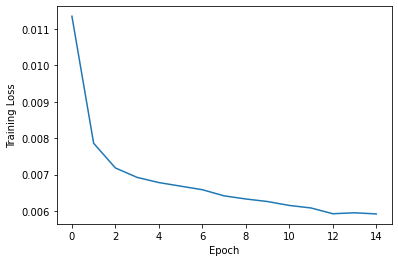

In [ ]:
## Training ##
EPOCH_NUM = 15
model, loss_function, optimizer, device = config_model()

losses = []
def training(dataloader):
  model.train()
  for epoch in range(EPOCH_NUM):
    sample_num = 0
    total_loss = 0
    correct = 0
    for x1, x2, y in dataloader:
      # each batch: 50 image pairs
      sample_num += x1.shape[0]
      x1 = x1.to(device)
      x2 = x2.to(device)
      y = y.to(device)
      
      model.zero_grad()
      out1, out2 = model(x1, x2)
      loss, dist = loss_function(out1, out2, y)

      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    acc = correct / sample_num
    average_loss= total_loss/sample_num
    losses.append(average_loss)
    print('Epoch:', epoch, '\tTraining Loss:', average_loss)
  
  fig, ax = plt.subplots()
  # ax.set_title("Training loss")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Training Loss")
  ax.plot(list(range(0, EPOCH_NUM)), losses);


training(pair_train_loader)

In [ ]:
## Evaluation ##
def evaluation(dataloader, label):
  model.eval()
  
  with torch.no_grad():
    pred_label = torch.empty((0, 5), dtype=torch.int64).cuda()
    true_label = label.astype(int)
    for x1, x2, y in dataloader:
      x1 = x1.to(device)
      x2 = x2.to(device)
      y = y.to(device)
      
      out1, out2 = model(x1, x2)
      dist = F.pairwise_distance(out1, out2)
      dist = dist.reshape((-1, 5))

      pred = (dist <= torch.mean(dist, dim=1, keepdim=True)).int()

      # Alternative: softmax
      # proc = nn.Softmax(dim=1)
      # dist = proc(dist)

      pred_label = torch.cat((pred_label, pred), 0)

  pred_label = pred_label.cpu().numpy()
  diff = pred_label - true_label
  FP = np.count_nonzero(diff == 1)
  FN = np.count_nonzero(diff == -1)
  acc = 1 - (FP + FN)/diff.size

  print(f"Test accuracy: {acc}")  # 0.883

evaluation(pair_test_loader, test_label)


Test accuracy: 0.8844


Test accuracy: 0.9044


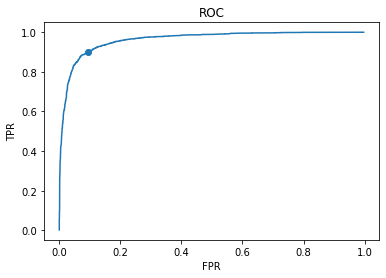

In [ ]:
import matplotlib.pyplot as plt
## Evaluation ##
def evaluation_ROC(dataloader, label):
  model.eval()
  
  with torch.no_grad():
    true_label = label.astype(int)
    similarity = []
    for x1, x2, y in dataloader:
      x1 = x1.to(device)
      x2 = x2.to(device)
      y = y.to(device)
      
      out1, out2 = model(x1, x2)
      cos = F.cosine_similarity(out1, out2, dim=1)
      similarity.extend(cos.cpu().numpy())

  similarity = np.array(similarity).reshape((true_label.shape[0], -1))

  thresholds = np.linspace(0.0, 1.0, num=10001)
  TPRs = []
  FPRs = []
  P = np.count_nonzero(true_label)
  N = true_label.size - sum(true_label)
  for t in thresholds:
    pred_label = (similarity >= t).astype(int)  # similarity判定与dist相反
    diff = pred_label - true_label
    FP = np.count_nonzero(diff == 1)
    TP = np.count_nonzero(pred_label == 1) - FP
    TPR = TP / P
    FPR = FP / N
    TPRs.append(TPR)
    FPRs.append(FPR)

  TPRs = np.array(TPRs)
  FPRs = np.array(FPRs)
  # find the point nearest to (0, 1) on ROC curve, get the corresbonding threshold
  index = np.argmin((np.power(FPRs, 2) + np.power(TPRs - 1, 2)))
  threshold = thresholds[index]
  
  fig, ax = plt.subplots()
  ax.set_title("ROC")
  ax.set_xlabel("FPR")
  ax.set_ylabel("TPR")
  ax.scatter(FPRs[index], TPRs[index])
  ax.plot(FPRs, TPRs);

  pred_label = (similarity >= threshold).astype(int)
  diff = pred_label - true_label
  FP = np.count_nonzero(diff == 1)
  FN = np.count_nonzero(diff == -1)
  acc = 1 - (FP + FN)/diff.size

  print(f"Test accuracy: {acc}")  # 0.8982

evaluation_ROC(pair_test_loader, test_label)
